In [1]:
import pandas as pd
from numpy import mean
import numpy as np
from tqdm import tqdm

#Sklearn 
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

#AI360 
from fairlearn.metrics import MetricFrame
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from aif360.datasets import StandardDataset
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.sklearn.metrics import equal_opportunity_difference
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing.lfr import LFR

# Graphs libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

from IPython.display import Markdown, display
#import plotly.offline as py
#py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools



In [2]:
# define dataset
data = pd.read_csv('dataset_ready2.csv') 
data = data.set_index('ORG_org_uuid')

#More cleaning
data = data.drop(['Unnamed: 0'], axis = 1)
data_orig = data.copy()
data = data.query('unknown_founders == 0 and female_founders != 0 or male_founders != 0')

data = data.drop(data[data.total_num_founders > 10].index)
data = data.drop(data[data.status == 'operating'].index)


In [3]:
cols_to_drop = ['company_name', 'category_list', 'category_group_list',
               'region', 'city', 'homepage_url', 'founded_on']
data.drop(columns = cols_to_drop, inplace = True)
#data_bef_scale = data.copy()

In [4]:
## CREATE A BINARY OUTCOME VARIABLE
data.replace('ipo', 1, regex = True, inplace = True)
data.replace('acquired', 1, regex = True, inplace = True)
data.replace('closed', 0, regex = True, inplace = True)

In [39]:
data.describe()

,city_success_ranking,region_rank,multiple_degrees_sum,multiple_degrees_average,is_completed_sum,is_completed_avg,work_experience_avg,work_experience_sum,education_time_avg,education_time_sum,...,female_founders,unknown_founders,total_num_founders,category_list1,category_list2,category_list3,category_group_list1,category_group_list2,category_group_list3,mostly_male_founders
count,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,...,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000,18467.000000
mean,0.651549,0.509259,0.539178,0.212246,0.539178,0.212246,611.411528,1332.396653,172.355784,357.518601,...,0.346943,0.074782,2.849461,210.234635,267.830942,11614.014025,14.749066,17.853631,2837.484486,0.894515
std,0.203345,0.274021,1.194603,0.385516,1.194603,0.385516,1579.023639,4016.656463,477.379581,1163.146205,...,0.759008,0.313573,2.200813,182.320013,215.108440,10496.298272,11.089382,14.197802,3048.394629,0.307186
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5133.000000,-16438.000000,-9131.000000,-9131.000000,...,0.000000,0.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,0.660886,0.406250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,54.000000,21.000000,-1.000000,5.000000,-1.000000,-1.000000,1.000000
50%,0.690277,0.619048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.000000,187.000000,257.000000,13362.000000,14.000000,21.000000,-1.000000,1.000000
75%,0.733528,0.716518,1.000000,0.200000,1.000000,0.200000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,4.000000,329.000000,420.000000,22792.000000,23.000000,27.000000,6411.000000,1.000000
max,1.000000,1.000000,10.000000,1.000000,10.000000,1.000000,12695.000000,70438.000000,9496.000000,13514.000000,...,9.000000,6.000000,10.000000,706.000000,715.000000,25325.000000,42.000000,44.000000,6671.000000,1.000000


### Transform to AIF360 compatible data 

In [5]:
privileged_groups = [{'mostly_male_founders': 1}]
unprivileged_groups = [{'mostly_male_founders': 0}]

dataset_orig = StandardDataset(data, 
                          label_name='status', 
                          favorable_classes=[1], 
                          protected_attribute_names=['mostly_male_founders'], 
                          privileged_classes=[[1]])

### Split into train, validation and test

In [6]:
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.75], shuffle=True, seed = 10)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.2], shuffle=True, seed = 10)


In [7]:
#help(StandardDataset.split)

In [8]:
#%%script false --no-raise-error
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print(dataset_orig_test.features.shape, "\n Percent of total %.2f" % (dataset_orig_test.features.shape[0]/
                                                             (dataset_orig.features.shape[0])*100), "%")
display(Markdown("#### Validation Dataset shape"))
print(dataset_orig_valid.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(13850, 21)


#### Test Dataset shape

(3694, 21) 
 Percent of total 20.00 %


#### Validation Dataset shape

(923, 21)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['mostly_male_founders']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['city_success_ranking', 'region_rank', 'multiple_degrees_sum', 'multiple_degrees_average', 'is_completed_sum', 'is_completed_avg', 'work_experience_avg', 'work_experience_sum', 'education_time_avg', 'education_time_sum', 'male_founders', 'female_founders', 'unknown_founders', 'total_num_founders', 'category_list1', 'category_list2', 'category_list3', 'category_group_list1', 'category_group_list2', 'category_group_list3', 'mostly_male_founders']


### Metric for the original training data

In [9]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes = %f" % metric_orig_train.mean_difference())
print("Disparate Impact = %f" %metric_orig_train.disparate_impact())


#print("Number of negatives male founders = %2.f" %metric_orig_train.num_negatives(privileged = True))
#print("Number of negatives female founders = %2.f" %metric_orig_train.num_negatives(privileged = False))
#print("Number of positives male founders = %2.f" %metric_orig_train.num_positives(privileged = True))
#print("Number of positives female founders = %2.f" %metric_orig_train.num_positives(privileged = False))

metric_orig_test = BinaryLabelDatasetMetric(dataset_orig_test, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original test dataset"))
print("Difference in mean outcomes = %f" % metric_orig_test.mean_difference())
print("Disparate Impact = %f" %metric_orig_test.disparate_impact())


#print("Number of negatives male founders = %2.f" %metric_orig_test.num_negatives(privileged = True))
#print("Number of negatives female founders = %2.f" %metric_orig_test.num_negatives(privileged = False))
#print("Number of positives male founders = %2.f" %metric_orig_test.num_positives(privileged = True))
#print("Number of positives female founders = %2.f" %metric_orig_test.num_positives(privileged = False))

#### Original training dataset

Difference in mean outcomes = -0.074371
Disparate Impact = 0.898739


#### Original test dataset

Difference in mean outcomes = -0.076516
Disparate Impact = 0.896921


### Train with and transform the original training data - Reweighing 
"Reweighing won't change the training data at all, rather it will learn new weights for each training row that will make the mean difference in outcomes between the specified groups 0."
https://www.kaggle.com/garethjns/titanicsexism-fairness-in-ml

In [10]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [11]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

### Metric with the transformed training data 

In [12]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())
assert np.abs(metric_transf_train.mean_difference()) < 1e-6


#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [13]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

## Train classifier on original data 

In [14]:
# Logistic regression classifier and predictions
scale_orig = MinMaxScaler()
X_train = scale_orig.fit_transform(dataset_orig_train.features)
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

lmod = LogisticRegression(solver='liblinear')
lmod.fit(X_train, y_train, 
         sample_weight=dataset_orig_train.instance_weights)
y_train_pred = lmod.predict(X_train)

# positive class index
pos_ind = np.where(lmod.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

### Scores for original validation and test sets 

In [15]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = scale_orig.transform(dataset_orig_valid_pred.features)
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = lmod.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_orig.transform(dataset_orig_test_pred.features)
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set 

In [16]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.7320
Optimal classification threshold (no reweighing) = 0.6534


In [17]:
from collections import OrderedDict
from aif360.metrics import ClassificationMetric
def compute_metrics(dataset_true, dataset_pred, 
                    unprivileged_groups, privileged_groups,
                    disp = True):
    """ Compute the key metrics """
    classified_metric_pred = ClassificationMetric(dataset_true,
                                                 dataset_pred, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    metrics = OrderedDict()
    metrics["Accuracy"] = classified_metric_pred.accuracy()
    metrics["Balanced accuracy"] = 0.5*(classified_metric_pred.true_positive_rate()+
                                             classified_metric_pred.true_negative_rate())
    metrics["Average odds difference"] = classified_metric_pred.average_odds_difference()
    metrics["Average absolute odds difference"] = classified_metric_pred.average_abs_odds_difference()
    metrics["Disparate impact"] = classified_metric_pred.disparate_impact()
    metrics["Statistical parity difference (mean difference)"] = classified_metric_pred.statistical_parity_difference()
    metrics["Equal opportunity difference"] = classified_metric_pred.equal_opportunity_difference()
    metrics["Theil index"] = classified_metric_pred.theil_index()
    metrics["Consistency"] = classified_metric_pred.consistency()
    ##ADD MORE METRICS FROM CLASSIFICATIONMETRIC HERE
    if disp:
        for k in metrics:
            print("%s = %.4f" % (k, metrics[k]))
    
    return metrics

## Predictions from the original test set at the optimal classification threshold


In [18]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.6534


 67%|██████████████████████████▏            | 67/100 [00:10<00:05,  6.56it/s]

Accuracy = 0.7718
Balanced accuracy = 0.7021
Average odds difference = -0.1121
Average absolute odds difference = 0.1121
Disparate impact = 0.8048
Statistical parity difference (mean difference) = -0.1481
Equal opportunity difference = -0.1274
Theil index = 0.1540
Consistency = 0.7421


100%|██████████████████████████████████████| 100/100 [00:15<00:00,  6.48it/s]


Feature: 0, Score: 0.37779
Feature: 1, Score: 0.52970
Feature: 2, Score: 0.02940
Feature: 3, Score: -0.03378
Feature: 4, Score: 0.02940
Feature: 5, Score: -0.03378
Feature: 6, Score: 0.15726
Feature: 7, Score: -0.29927
Feature: 8, Score: 0.04595
Feature: 9, Score: 0.44654
Feature: 10, Score: 0.26914
Feature: 11, Score: 0.03278
Feature: 12, Score: -0.06379
Feature: 13, Score: 0.23943
Feature: 14, Score: -0.04229
Feature: 15, Score: -0.06383
Feature: 16, Score: 0.19342
Feature: 17, Score: 0.17185
Feature: 18, Score: 0.09225
Feature: 19, Score: 0.00130
Feature: 20, Score: -0.07194


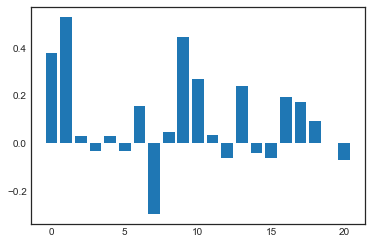

In [32]:
importance = lmod.coef_[0]

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

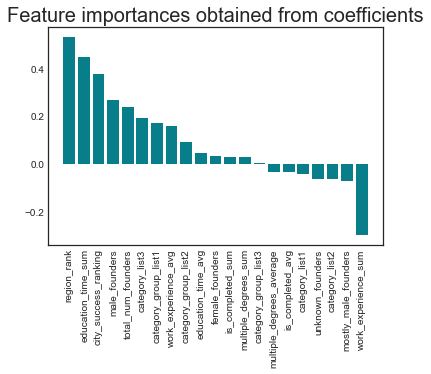

### Display results for all thresholds - original test data: abs(1-disparate impact)
Shows that best threshold is at 0,712 (See dotted line in graph below)
abs(1-disparate impact) must be small (close to 0) for classifier predictions to be fair.
The threshold states at which probability LogReg should output 0 or 1. 

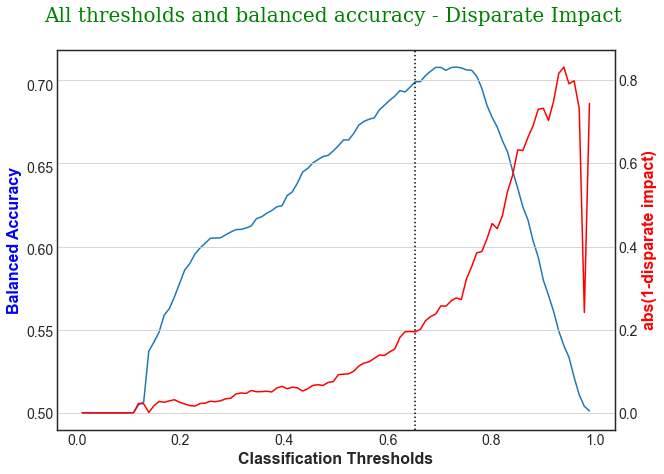

In [19]:
font1 = {'family':'serif','color':'green','size':20}
fig, ax1 = plt.subplots(figsize=(10,7))
plt.title("All thresholds and balanced accuracy - Disparate Impact \n", fontdict = font1)
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

### Display results for all thresholds - original test data: avg odds difference 



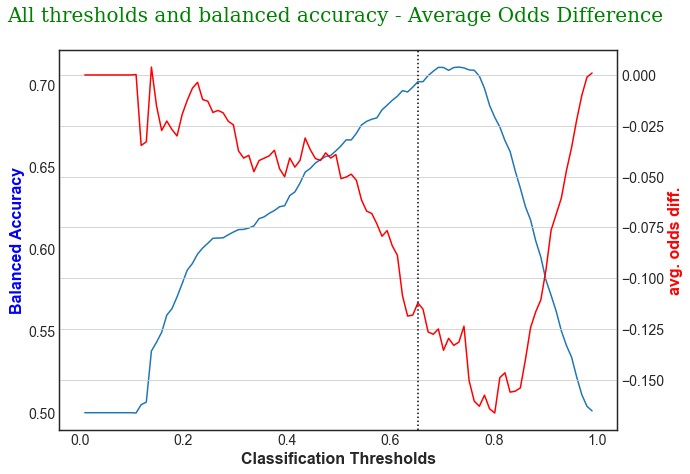

In [20]:
##The classification threshold states at what probability logreg should say 0 or 1.
fig, ax1 = plt.subplots(figsize=(10,7))
plt.title("All thresholds and balanced accuracy - Average Odds Difference \n", fontdict = font1)
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

## Train classifier on transformed data

In [21]:
scale_transf = StandardScaler()
X_train = scale_transf.fit_transform(dataset_transf_train.features)
y_train = dataset_transf_train.labels.ravel()

lmod = LogisticRegression(solver='liblinear')
lmod.fit(X_train, y_train,
        sample_weight=dataset_transf_train.instance_weights)
y_train_pred = lmod.predict(X_train)

### Obtain scores for transformed test set 

In [22]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = scale_transf.fit_transform(dataset_transf_test_pred.features)


y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = lmod.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

In [23]:
#print(classification_report(dataset_orig_test.labels, dataset_transf_test.labels))

## Predictions from the transformed test set at the optimal classification threshold


In [24]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.6534


 67%|██████████████████████████▏            | 67/100 [00:10<00:04,  6.67it/s]

Accuracy = 0.7710
Balanced accuracy = 0.6993
Average odds difference = -0.0034
Average absolute odds difference = 0.0341
Disparate impact = 0.9390
Statistical parity difference (mean difference) = -0.0458
Equal opportunity difference = -0.0375
Theil index = 0.1532
Consistency = 0.7421


100%|██████████████████████████████████████| 100/100 [00:15<00:00,  6.64it/s]


In [25]:
metric_test_aft.disparate_impact

AttributeError: 'collections.OrderedDict' object has no attribute 'disparate_impact'

### Display results for all thresholds - transformed data: abs(1-disparate impact) 


In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
plt.title("All thresholds and balanced accuracy - Disparate Impact \n", fontdict = font1)
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

### Display results for all thresholds - transformed data: average odds difference



In [ ]:
fig, ax1 = plt.subplots(figsize=(10,7))
plt.title("All thresholds and balanced accuracy - Average Odds Difference \n", fontdict = font1)
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)
ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)